In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
from rasterio.plot import show
import rasterio as rio
import rasterio.features
import rasterio.warp
import earthpy.spatial as es
import tarfile
import os
from shapely.geometry import Polygon
from matplotlib import pyplot
import matplotlib.pyplot as plt
import json
import pickle
import pyproj;                                 #pyproj.set_datapath("C:/Users/User/Anaconda3/envs/geo/Lib/site-packages/pyproj")
import landsatxplore.api
from landsatxplore.earthexplorer import EarthExplorer                                  # https://pypi.org/project/landsatxplore/
from collections.abc import Iterable
import time
import math
from ipypb import track
import seaborn as sn
from ipyleaflet import Map, GeoData, basemaps, LayersControl

os.chdir(r"C:\Users\User\Documents\Work\SDGs and AI\6.3.2")

### Read in list of sites for download

In [2]:
#sites = pickle.load(open("sites.p","rb"))
sites = pd.read_pickle("sites.p")

In [3]:
### example site

sid = 'EL000200030020H500'

### Read shapefile

In [4]:
polygon = gp.read_file("./Shapefiles/doksa.shp")

# polygon = polygon.to_crs(sites.crs)

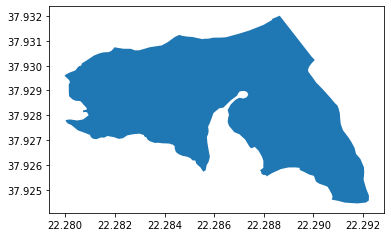

In [5]:
polygon.plot()

In [6]:
m = Map(center=(37.93007,22.28925 ), zoom = 14, basemap = basemaps.Esri.WorldTopoMap)

lakes_plot = GeoData(geo_dataframe = polygon,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Large Lakes')

lakes_point = GeoData(geo_dataframe = sites.loc[sid,],
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                name = 'Large Lakes')

m.add_layer(lakes_plot)
m.add_layer(lakes_point)
m.add_control(LayersControl())

m

Map(center=[37.93007, 22.28925], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

### Clip and mask raster to polygon

#### Create function for cropping raster

In [7]:
def cropper(raster, geoms, outpath):
    """
    This function accepts a raster object, an interable list of geometrys (or a single geometry),
    and a filepath to save the cropped raster to, the cropped raster is then read back in and returned.
    """    
    ## As crop accepts an iterable of geoms we first put any single geoms into a list
    if not isinstance(geoms, Iterable):
        geoms = [geoms]

    ## Next we crop the image
    raster_crop, raster_crop_meta = es.crop_image(raster, geoms)

    ## We now need to update the metadata with the spatial data
    raster_crop_meta.update({'transform': raster_crop_meta['transform'],
                             'height': raster_crop.shape[1],
                             'width': raster_crop.shape[2],
                             'nodata': raster_crop.min()}) # <- This is the 'mask' value
    
    with rio.open(outpath, 'w', **raster_crop_meta) as file:
        file.write(raster_crop[0], 1)
        
    raster_crop = rio.open(outpath)
    
    return raster_crop

#### Run function on downloaded rasters and save to new directory

In [59]:
### set path for downloaded files
path = './Landsat/Downloaded/'
c_path = './Landsat/Cropped/'

### List tif files in download directory to process
dl_files = os.listdir(path)
tif_files = [ i for i in dl_files if '.tif' in i ]


while len(tif_files)>0:

    for tif in tif_files:  ### AMEND TO be for specific scene

        with rio.open(path+tif) as src:
        
            ## set polygon to crs of raster
            polygon_newcrs = polygon.to_crs(src.crs)
            polygon_geom = polygon_newcrs.loc[0, 'geometry']
            
            try:
            
            ## crop raster to polygon extent
                cropped = cropper(src, polygon_geom, c_path+tif)
                
            except: 
                print(tif+' and polygon do not intercept')
                crop_exceptions = []
                crop_exceptions += tif

            ## close and delete uncropped version
            src.close()
        
            os.remove(path+tif)

        ## update files list
        dl_files = os.listdir(path)
        tif_files = [ i for i in dl_files if '.tif' in i ]
        
        break
            
if len(tif_files)==0:
    print('No tifs to crop')


No tifs to crop


C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\numpy\ma\core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
C:\Users\User\Anaconda3\envs\geo\lib\site-packages\matplotlib\image.py

<ipython-input-61-f35ac75d2d4e>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=150, figsize =(8, 3))
<ipython-input-61-f35ac75d2d4e>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=150, figsize =(8, 3))
<ipython-input-61-f35ac75d2d4e>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

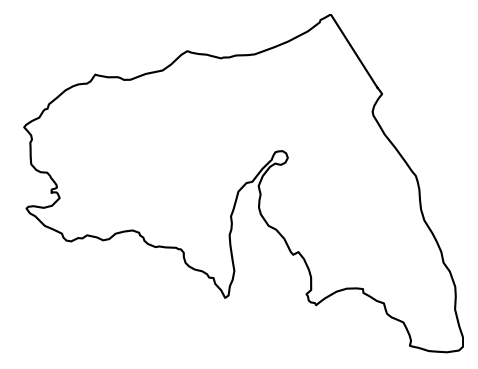

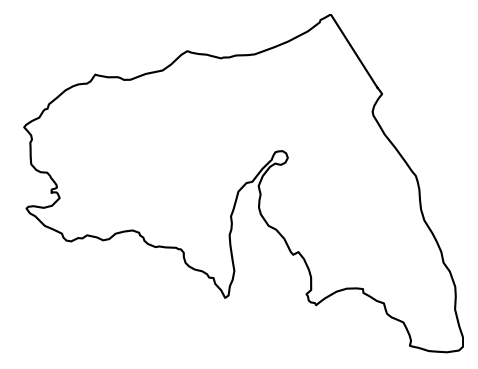

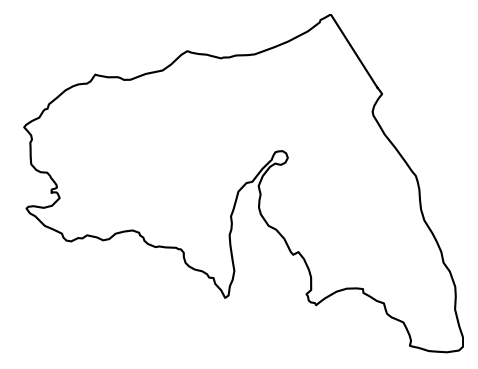

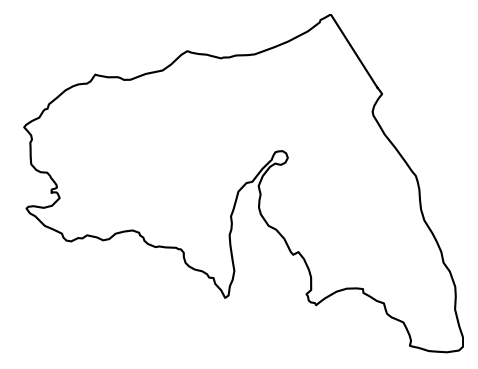

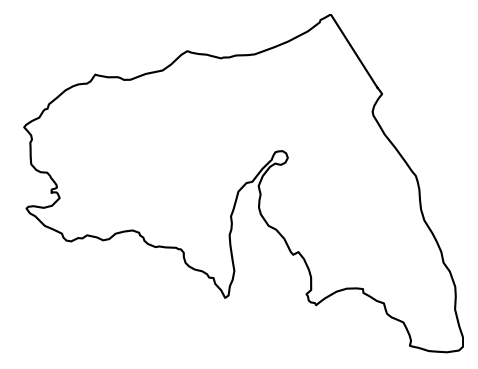

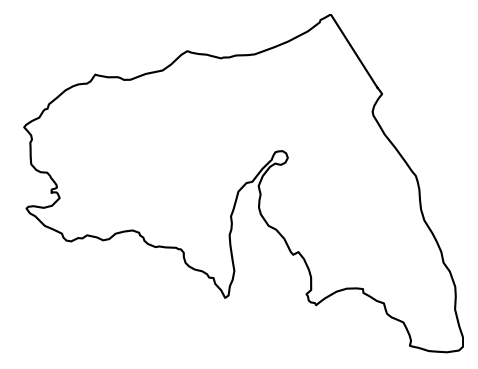

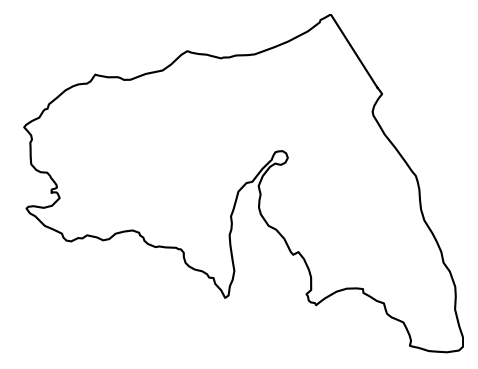

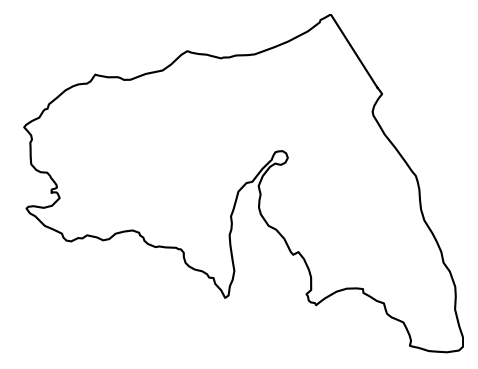

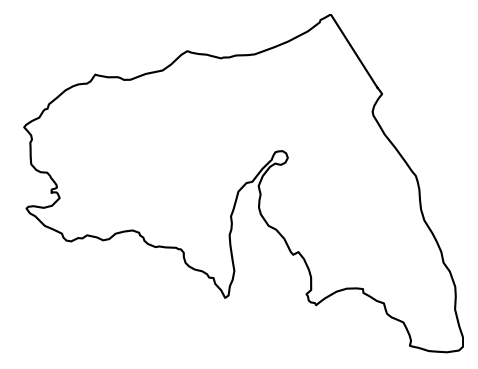

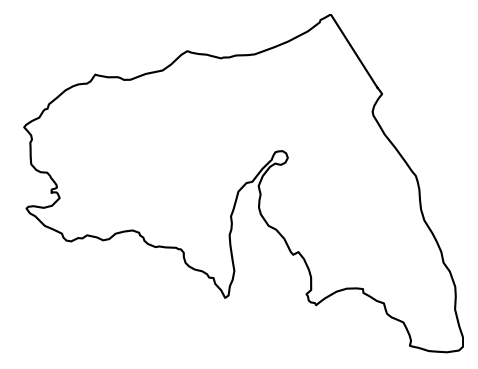

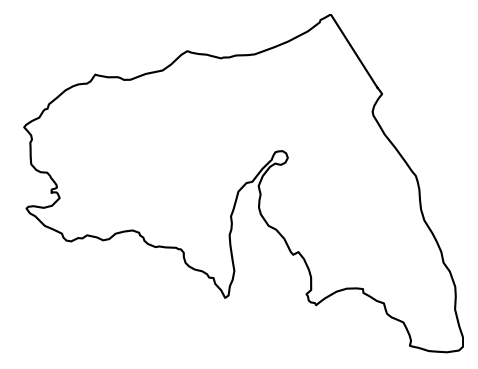

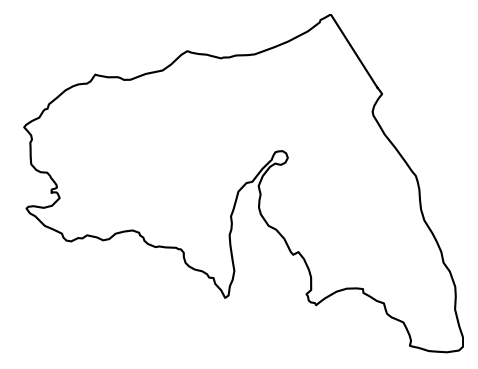

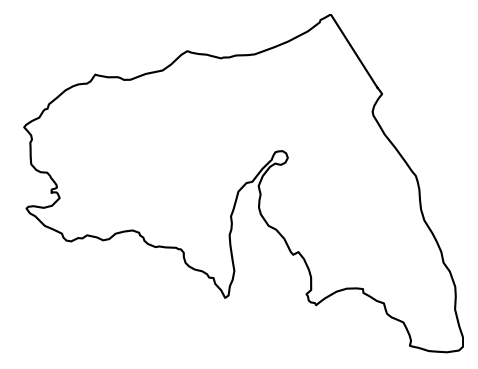

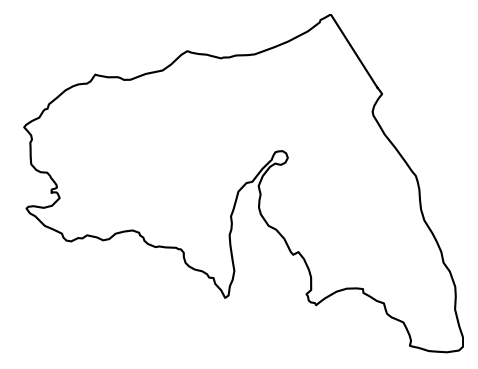

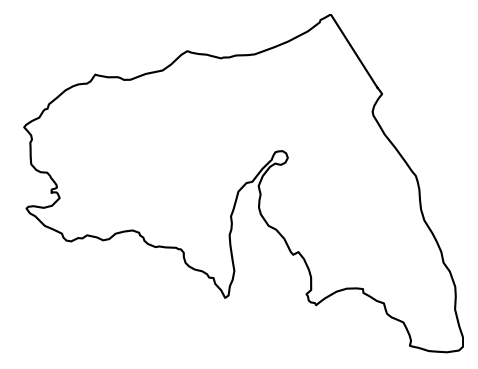

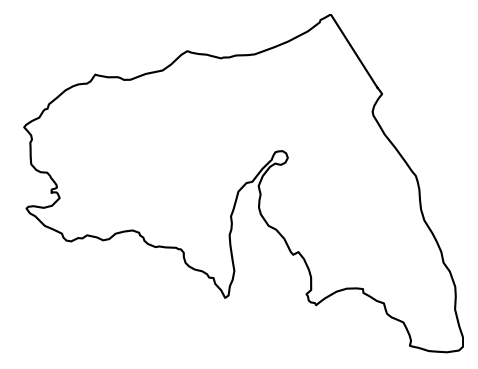

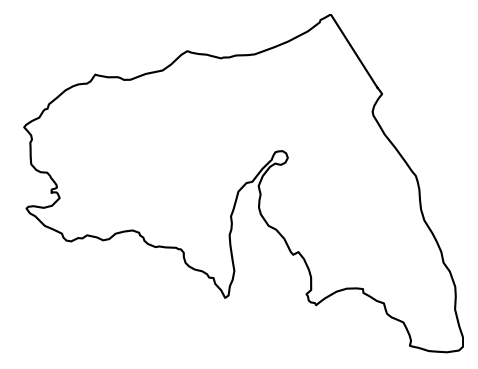

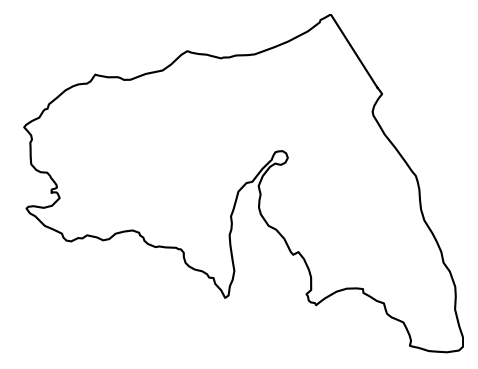

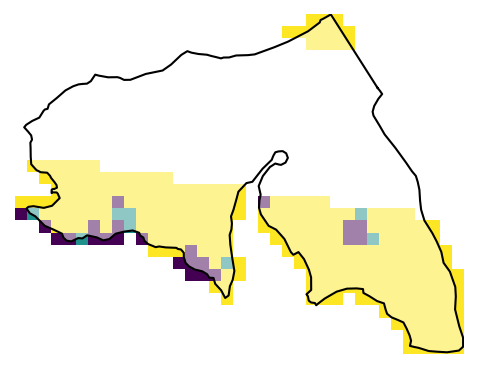

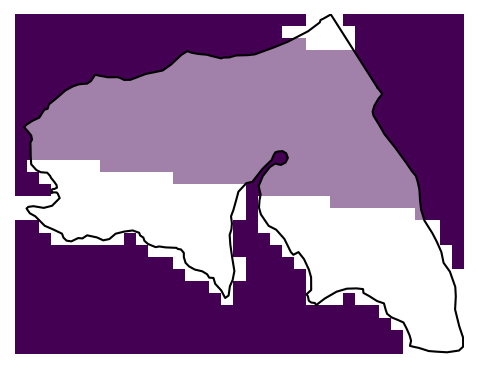

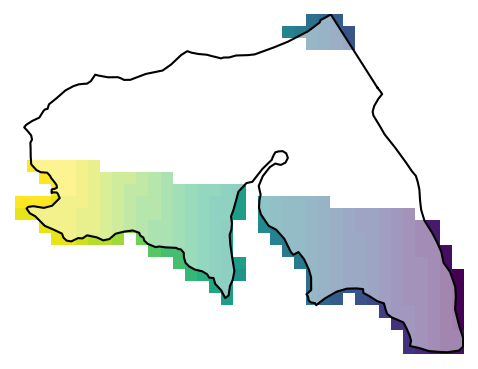

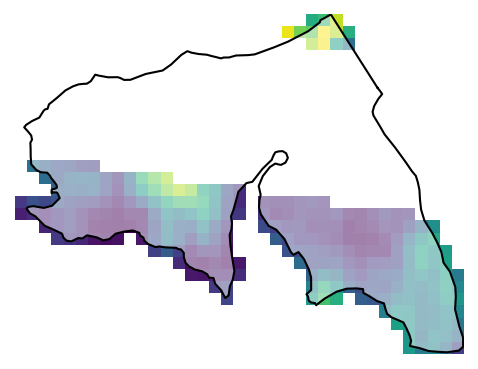

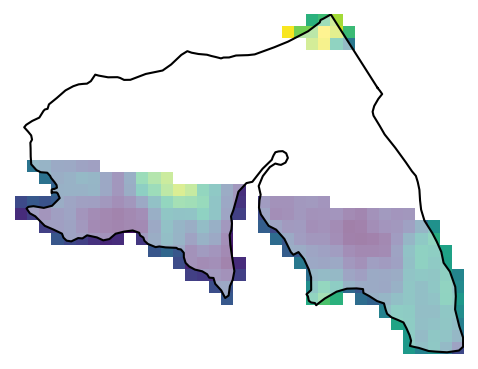

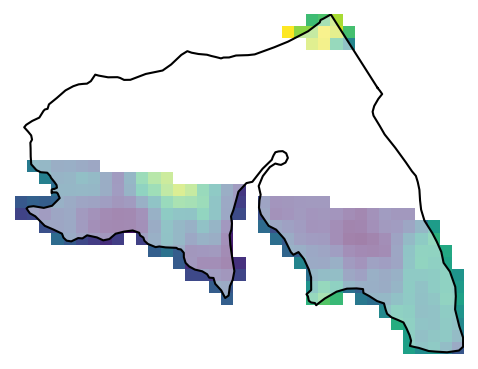

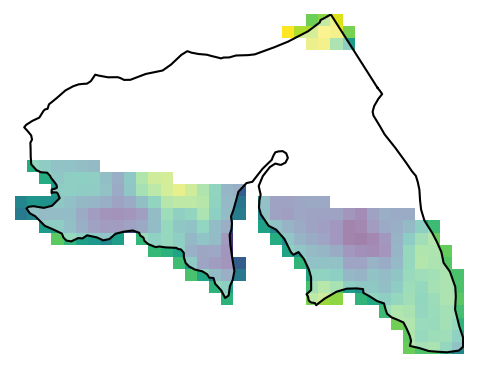

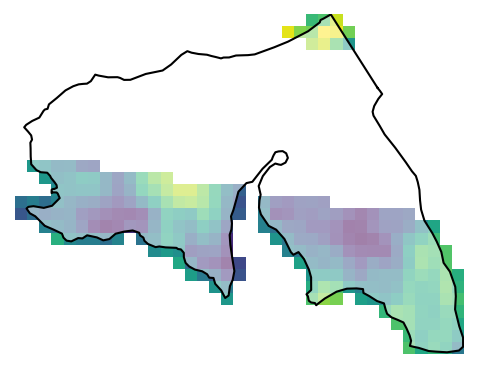

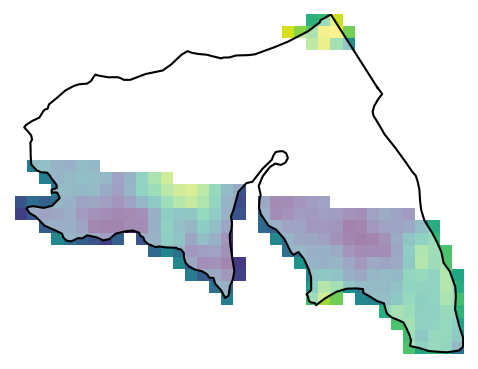

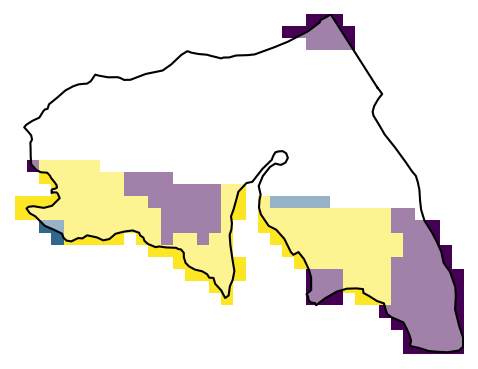

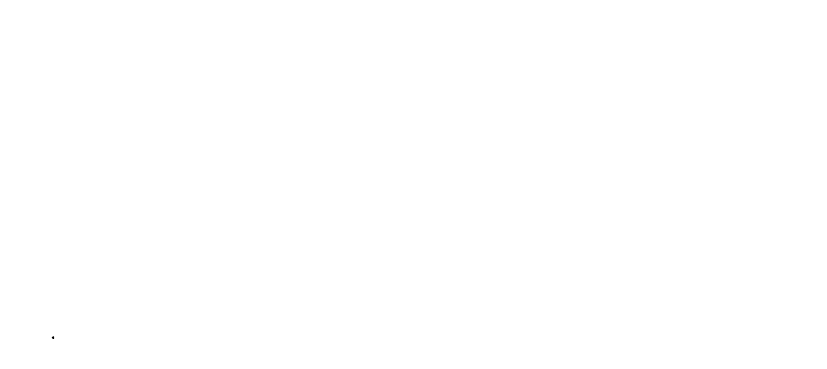

In [61]:
dl_files = os.listdir(c_path)
c_tif_files = [ i for i in dl_files if '.tif' in i ]

for tif in c_tif_files:
    
    with rio.open(c_path+tif) as src:
        
        fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

        show(src, ax=ax)
        polygon_newcrs.plot(alpha=0.5, color='white', ax=ax) # We plot both the filled in polygon
        ax.plot(*polygon_geom.exterior.xy, color='k', linewidth=1) # And add a darker border

        ax.set_axis_off()

### Save local file version with downloaded setting

In [ ]:
localname = 'LC08_L1TP_042034_20170616_20170629_01_T1_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

### Plot raster

https://geohackweek.github.io/raster/04-workingwithrasters/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


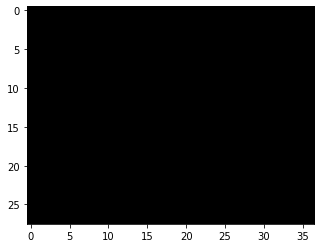

In [11]:
import matplotlib.image as mpimg

b1 = rio.open('./Landsat/Cropped/LC08_L1TP_184033_20130726_20180527_01_T1_sr_band1.tif')
b2 = rio.open('./Landsat/Cropped/LC08_L1TP_184033_20130726_20180527_01_T1_sr_band2.tif')
b3 = rio.open('./Landsat/Cropped/LC08_L1TP_184033_20130726_20180527_01_T1_sr_band3.tif')

b1 = b1.read(1)
b2 = b2.read(1)
b3 = b3.read(1)

rgb = np.dstack((b1,b2,b3))
    

plt.imshow(rgb)

plt.show()

C:\Users\User\Anaconda3\envs\geo\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


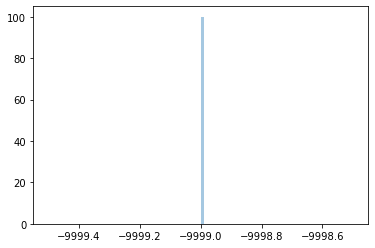

In [12]:
### 65,536 for 16-bit

import seaborn as sn

sn.distplot(rgb,bins=100)

### Look at netCFD xarray

In [29]:
# Read the src's valid data mask as a ndarray.
mask = src.dataset_mask()

# Extract feature shapes and values from the array.
for geom, val in rio.features.shapes(
        mask, transform=src.transform):

    # Transform shapes from the src's own coordinate
    # reference system to CRS84 (EPSG:4326).
    geom = rio.warp.transform_geom(
        src.crs, 'EPSG:4326', geom, precision=6)

    # Print GeoJSON shapes to stdout.
    print(geom)

SyntaxError: unexpected EOF while parsing (<ipython-input-29-dc499ada0354>, line 16)

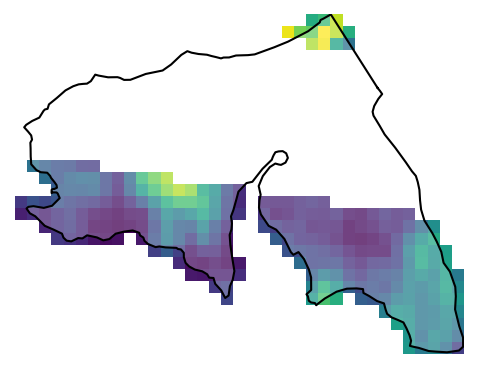

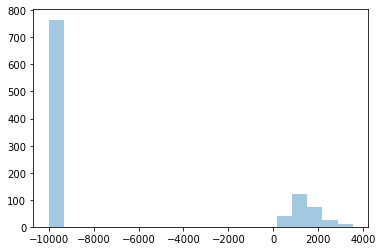

In [47]:
path = './Landsat/Cropped/'

with rio.open(path+'LE07_L1TP_183034_20130609_20161124_01_T1_sr_band1.tif') as src:

    polygon_newcrs = polygon.to_crs(src.crs)
    polygon_geom = polygon_newcrs.loc[0, 'geometry']
    
    fig, ax = plt.subplots(dpi=150, figsize =(8, 3))

    show(src, ax=ax)
    polygon.plot(alpha=0.25, color='white', ax=ax) # We plot both the filled in polygon
    ax.plot(*polygon_geom.exterior.xy, color='k', linewidth=1) # And add a darker border

    ax.set_axis_off()
    
    plt.show()
    
    sn.distplot(src.read(),kde=False,bins=20)